In [1]:
import pandas as pd
from SALib.sample.morris import sample
import os

### 1. Morris parameter set generation

In [2]:
def create_morris_parameter_set(file_path, sheet_name):
    """"
    Generates parameter sets for the morris problem.

    """
    
    df = pd.read_excel(file_path, sheet_name = sheet_name).iloc[:,:4]
    print(len(df))
    num_vars = len(df)
    names = list(df.iloc[:,0])
    names = [n.strip() for n in names]
    bounds = [[df.iloc[i,2], df.iloc[i,3]]for i in range(len(df))]
    print(names)
    crop_problem_definition_morris = {"num_vars" : num_vars,
                                    "names" : names,
                                    "bounds" : bounds
                                    }
    param_values = sample(problem = crop_problem_definition_morris,
                                                N = 500, num_levels = 20,
                                                optimal_trajectories = 40,
                                                local_optimization = True,
                                                seed = 20)
    
    df = pd.DataFrame(param_values, columns=names)
    folder = os.path.dirname(file_path)
    path_save = os.path.join(folder, sheet_name + "_morris.xlsx")
    df.to_excel(path_save, index = False)
    return df


In [3]:
# file_path = r'C:\Users\Pandit\Desktop\sa_analysis\sa_morris_def_parameters.xlsx'
# sheet_name = 'sugarbeet'
# x = create_morris_parameter_set(file_path, sheet_name)
# # # len(x)

### Morris analysis

#### Problem definition

In [4]:
def morris_problem(morris_problem_df, sheet_name):

    "Creates Problem definition for the Morris Sampling"
    df_parameters = pd.read_excel(morris_problem_df, sheet_name = sheet_name, header =[0])
    parameters_name = df_parameters.iloc[:,0].to_list()
    lower_bounds = df_parameters.iloc[:,2].to_list()
    upper_bounds = df_parameters.iloc[:,3].to_list()
    bounds = [x for x in zip(lower_bounds, upper_bounds)]
    variables = len(parameters_name)
    problem_definitions = {
        "num_vars": variables,
        "names": parameters_name,
        "bounds": bounds
    } 
    return problem_definitions


In [5]:
morris_sugarbeet = morris_problem(r'C:\Users\Pandit\Desktop\sa_analysis\sa_morris_def_parameters.xlsx', sheet_name = 'sugarbeet')

#### Reading reasults of the morris parameters analysis

In [6]:
def read_morris(morris_params, morris_yield, morris_irr, morris_sm, obs_sm_path):
    "Reads the parameters sets and model simulation for the parameters screening"
    # 1. read parameters sets
    df_parameters = pd.read_csv(morris_params, index_col = 0)
    parameters = df_parameters.to_numpy()
    print(parameters.shape)

    # 2. read model outputs for the parameter sets
    # yield array
    yield_df = pd.read_csv(morris_yield, index_col = 0).to_numpy()
    print(yield_df.shape)

    # irr array
    irr_df = pd.read_csv(morris_irr, index_col = 0).to_numpy()
    print(irr_df.shape)

    # sm_30 array
    moist_df = pd.read_csv(morris_sm, index_col = 0)
    long_sm = moist_df.T
    long_sm = long_sm.reset_index().rename(columns={'index': 'Date'})
    long_sm.columns = ['Date'] + [f'set_{i}' for i in range(0, moist_df.shape[0])]

    # obs sim to rxtract the common date readings
    obs = pd.read_excel(obs_sm_path)
    merge = pd.merge(long_sm, obs, on = 'Date', how = 'inner')
    sm_df = merge.T.iloc[1:-1, :].to_numpy()
    sm_df = sm_df.astype(float)

    print(sm_df.shape)

    return parameters, yield_df, irr_df, sm_df, 

In [7]:
import numpy as np
parameters, yield_df, irr_df, sm_df = read_morris(r"C:\Users\Pandit\Desktop\monica_win64_3.6.32.toth_ser_TUA\projects\sugarbeet_morris_sa_optimal\results_morris\sugarbeet_morris.txt",
                                                  r"C:\Users\Pandit\Desktop\monica_win64_3.6.32.toth_ser_TUA\projects\sugarbeet_morris_sa_optimal\results_morris\sugarbeet_yld.txt",
                                                  r'C:\Users\Pandit\Desktop\monica_win64_3.6.32.toth_ser_TUA\projects\sugarbeet_morris_sa_optimal\results_morris\sugarbeet_irr.txt',
                                                  r"C:\Users\Pandit\Desktop\monica_win64_3.6.32.toth_ser_TUA\projects\sugarbeet_morris_sa_optimal\results_morris\sugarbeet_sm.txt",
                                                  r"C:\Users\Pandit\Desktop\monica_win64_3.6.32.toth_ser_TUA\field_obs_data\sugarbeet_sm_opt_condition.xlsx")
                                                

(3080, 76)
(3080, 7)
(3080, 7)
(3080, 88)


#### Reading the observation values to calculate the objective functions

In [8]:
def read_observation(obs_yield_path, sheet_name, irr_path, sm_path):
    yield_df = pd.read_excel(obs_yield_path, sheet_name = sheet_name)
    # yield obs
    obs_yield = yield_df.iloc[0:7,1].to_numpy() # these are hardcoded if the year is changed the data will be different
    print(obs_yield.shape)

    # irr obs
    irr_data = pd.read_excel(irr_path)
    obs_irr = irr_data.iloc[0:7,1].to_numpy() # this is also hardcoded index
    print(obs_irr.shape)

    # sim obs
    sim_obs = pd.read_excel(sm_path)
    sim_obs["Date"] = pd.to_datetime(sim_obs["Date"])
    sim_30 = sim_obs.iloc[:,0:2]
    sim_30 = sim_30[sim_30["Date"]< "2015-09-30"]  # date is also hardcoded here
    obs_sim = sim_30.iloc[:,1].to_numpy()
    # moisture measured date timeseries
    moist_date = sim_30.iloc[:,0].to_numpy()

    print(obs_sim.shape)

    return obs_yield, obs_irr, obs_sim, moist_date

    

In [9]:
obs_yield, obs_irr, obs_sim, moist_date = read_observation(
    r"C:\Users\Pandit\Desktop\monica_win64_3.6.32.toth_ser_TUA\field_obs_data\obs_yield_opt_condition.xlsx", 
    "Sugarbeet", 
    r'C:\Users\Pandit\Desktop\monica_win64_3.6.32.toth_ser_TUA\field_obs_data\sugarbeet_irr_opt_condition.xlsx',
    r"C:\Users\Pandit\Desktop\monica_win64_3.6.32.toth_ser_TUA\field_obs_data\sugarbeet_sm_opt_condition.xlsx") 

(7,)
(7,)
(88,)


#### Now function to calculate the objectives to identify sensitive parameters

In [10]:
def objectives_calcn(yield_df, irr_df, sm_df, obs_yield, obs_irr, obs_sim):
    # yield error
    pbias_yield = 100 * (yield_df.sum(axis=1) - obs_yield.sum()) / obs_yield.sum()
    mae_yield = np.mean(np.abs(yield_df - obs_yield), axis = 1)
    rmse_yield = np.sqrt(np.mean((yield_df - obs_yield)**2, axis = 1))
    
    # irr error
    pbias_irr = 100 * (irr_df.sum(axis=1) - obs_irr.sum()) / obs_irr.sum()
    mae_irr = np.mean(np.abs(irr_df - obs_irr), axis = 1)
    rmse_irr = np.sqrt(np.mean((irr_df - obs_irr)**2, axis = 1))
    
    # soil moisture error
    pbias_sm = 100 * (sm_df.sum(axis=1) - obs_sim.sum()) / obs_sim.sum()
    mae_sm = np.mean(np.abs(sm_df - obs_sim), axis = 1)
    rmse_sm = np.sqrt(np.mean((sm_df - obs_sim)**2, axis = 1))

    return pbias_yield, mae_yield, rmse_yield, pbias_irr, mae_irr, rmse_irr, pbias_sm, mae_sm, rmse_sm

In [11]:
pbias_yield, mae_yield, rmse_yield, pbias_irr, mae_irr, rmse_irr, pbias_sm, mae_sm, rmse_sm = objectives_calcn(yield_df, irr_df, sm_df, 
                                                                                                               obs_yield, obs_irr, obs_sim)

#### Morris analysis and plotting

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
from SALib.analyze import morris

In [13]:
def covariance_plot(ax, Si, opts=None, unit=""):
    """Plots mu* against sigma or the 95% confidence interval"""
    if opts is None:
        opts = {}

    if Si["sigma"] is not None:
        # sigma is not present if using morris groups
        y = Si["sigma"]
        out = ax.scatter(Si["mu_star"], y, c="k", marker=".", **opts)
        ax.set_ylabel(r"$\sigma$")

        ax.set_xlim(
            0,
        )
        ax.set_ylim(
            0,
        )

        x_axis_bounds = np.array(ax.get_xlim())
    else:
        y = Si["mu_star_conf"]
        out = ax.scatter(Si["mu_star"], y, c="k", marker=".", **opts)
        ax.set_ylabel(r"$95\% CI$")

    ax.set_xlabel(r"$\mu^\star$ " + unit)
    ax.set_ylim(
        0 - (0.01 * np.array(ax.get_ylim()[1])),
    )

    return out

In [14]:
def morris_covariance(obj_function, parameters, plot_title, problem_morris, resamples =100):

    
    problem_analyze = morris.analyze(problem_morris, X = parameters, Y = obj_function, 
                                     num_levels = 20, scaled = True, num_resamples = resamples,
                                    conf_level = 0.95)

    fig, ax = plt.subplots(1, figsize = (12,8))
    
    covariance_plot(ax, problem_analyze, unit = " ", )
    entries = []                                                     #mu*:{name, sigma}. mu as key, because also ranking in label
    for i in range(len(problem_analyze['mu_star'])):
        mu = problem_analyze['mu_star'][i]
        sigma = problem_analyze['sigma'][i]
        name = problem_analyze['names'][i].strip()
        mu_conf = problem_analyze['mu_star_conf'][i]
        # print(name, mu)
        if mu ** 2 + sigma ** 2 > 0.04:
            entries.append((mu, sigma, name,mu_conf))
    
    # Sort by mu descending
    entries.sort(reverse=True, key=lambda x: x[0])
    x_, y_, label_, conf_ = zip(*entries)
    x_ = np.array(x_)
    y_ = np.array(y_)
    label_ = list(label_)
    conf_ = np.array(conf_)
    label_ = [str(x) for x in label_]
    for _ in range(len(x_)):
                #label = f"{label_[_]}_{x_[_]}
        # ax.hlines(y_[_], xmin = x_[_]-conf_[_], xmax= x_[_]+conf_[_], color = "black", alpha = 0.5)
        ax.scatter(x = x_[_], y = y_[_], label = f"{label_[_]}", marker = "o")
        
        # ax.scatter(x = x_[_]+conf_[_], y = y_[_], marker = "x")
        # ax.scatter(x = x_[_]-conf_[_], y = y_[_], marker = "x")
    ax.set_title(plot_title)
    ax.set_xticks(np.arange(0,1.1,0.1))
    ax.set_yticks(np.arange(0,1.1,0.1))
    
    (line1,) = ax.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), "k-.")         # , label = "slope = 1")
    # (line2,) = ax.plot(np.arange(0,1.1,0.1), 0.5 *np.arange(0,1.1,0.1) , "k--")
    # (line3,) = ax.plot(np.arange(0,1.1,0.1), 0.1 *np.arange(0,1.1,0.1), "k-.")
    circle = plt.Circle((0,0), 0.2,color='#b9c4c9', fill=True, linestyle='--', alpha = 0.8, hatch = "///")
    ax.add_patch(circle)
    ax.set_ylim(0,1)
    ax.set_xlim(0,1)
    ax.legend(title = "Sensitive parameters \nranked by μ*")
    plt.tight_layout()
    # ax.grid()
    # fig.savefig(plot_title, dpi=300, bbox_inches='tight')
    plt.show()
    # files.download(f"{plot_title}.png")
    return label_, problem_analyze

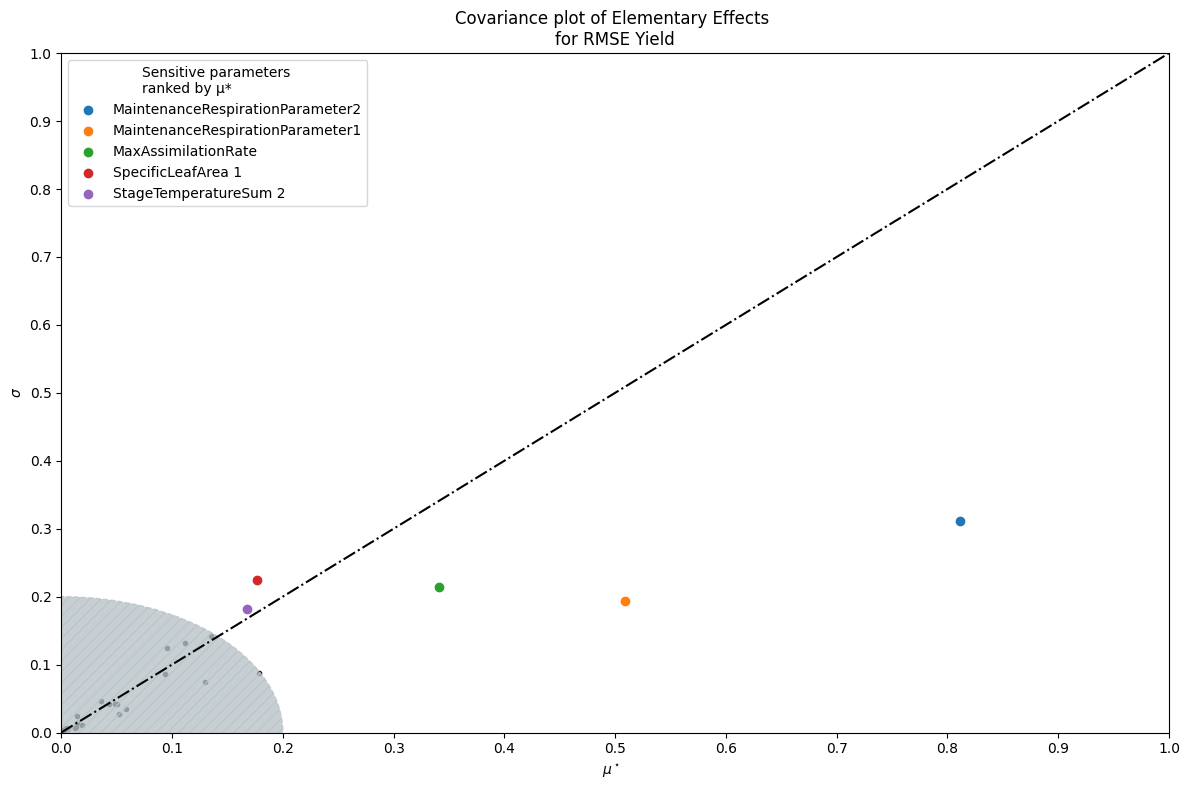

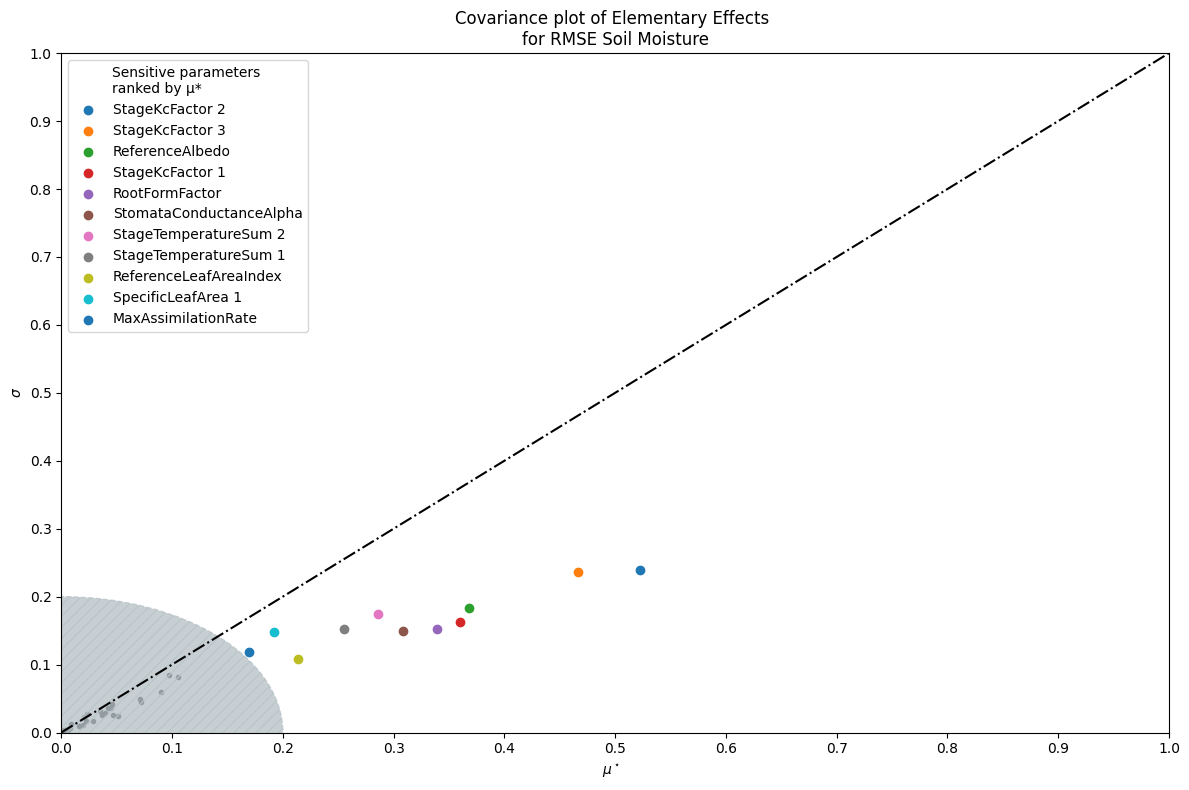

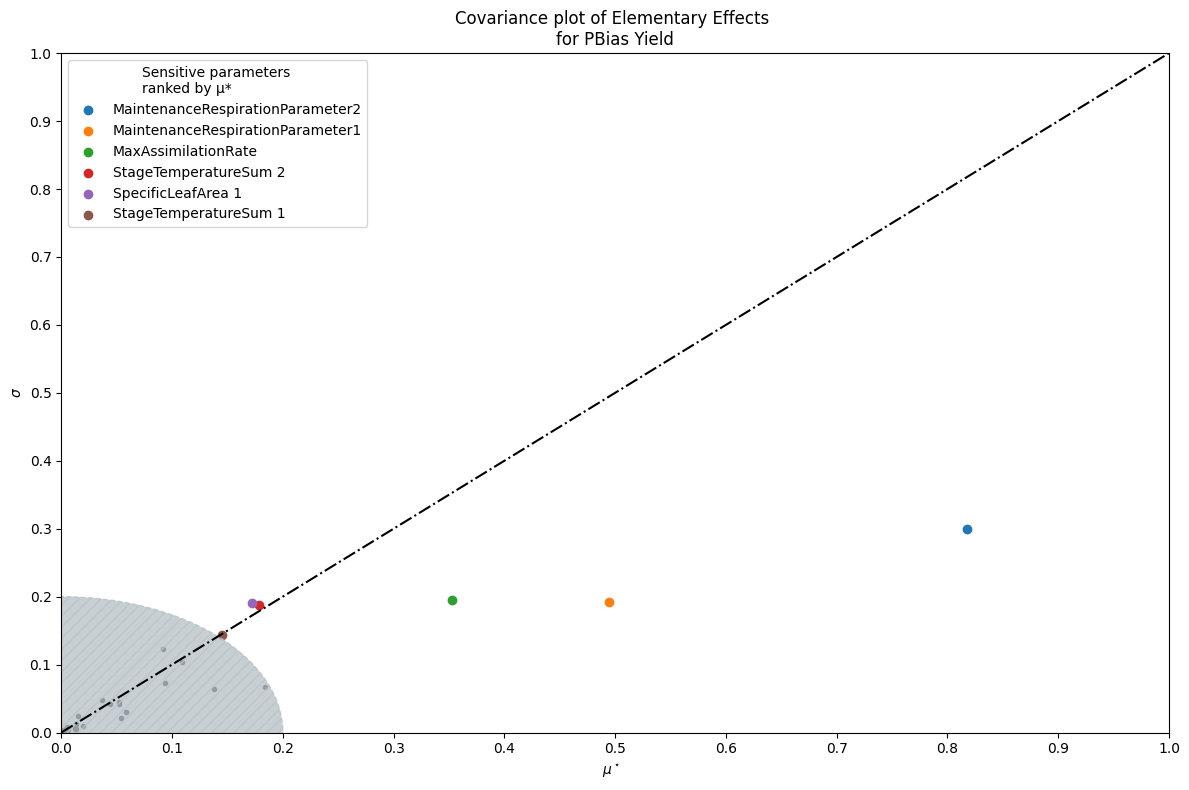

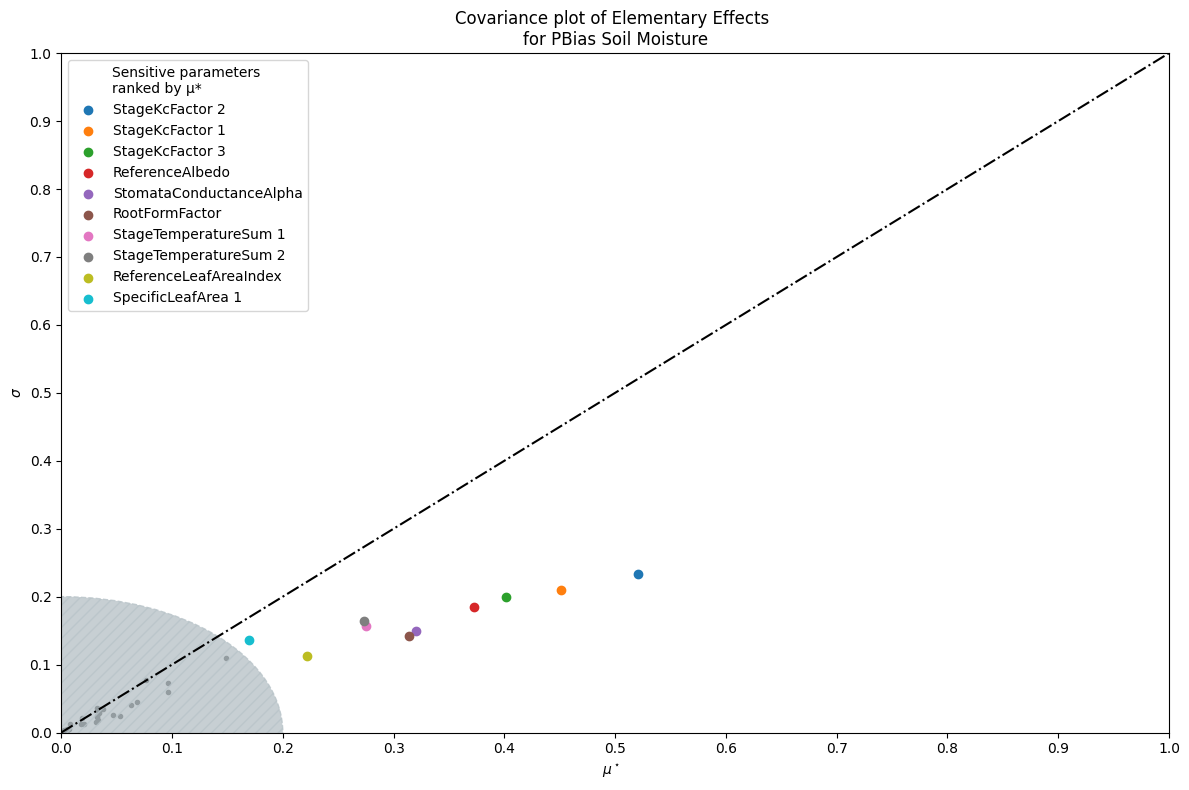

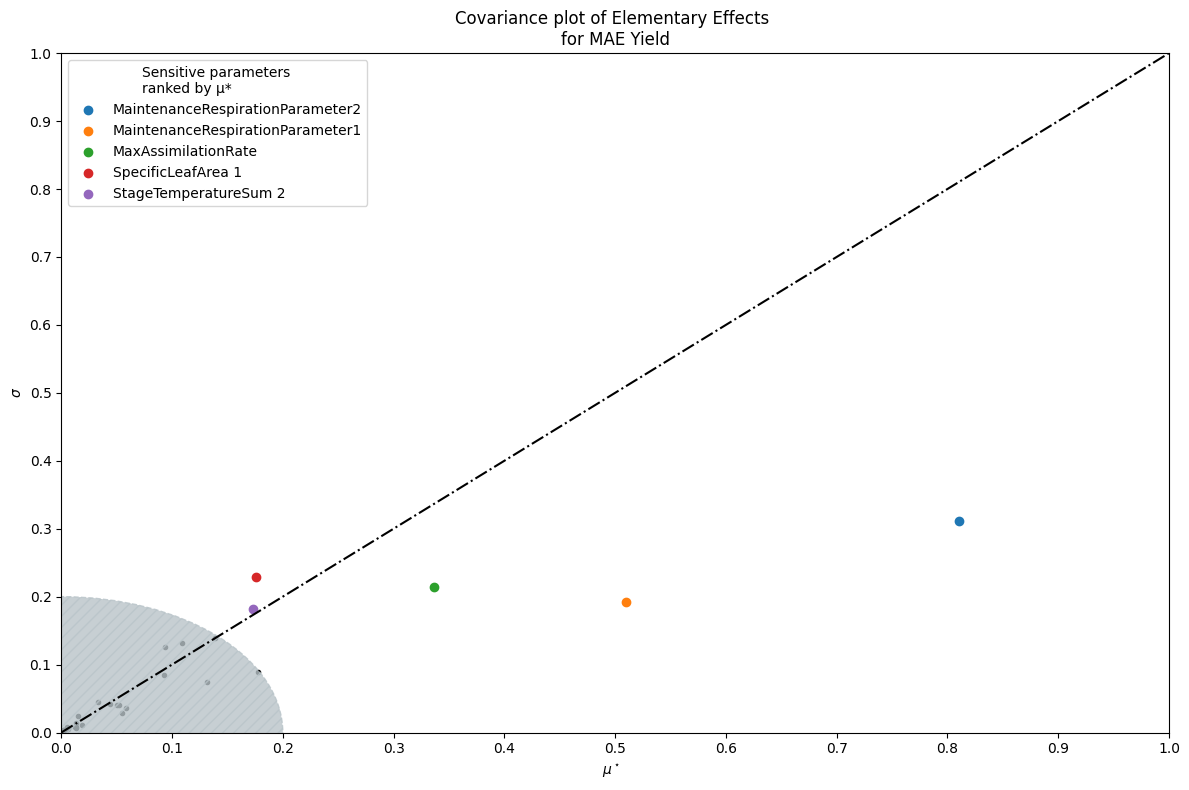

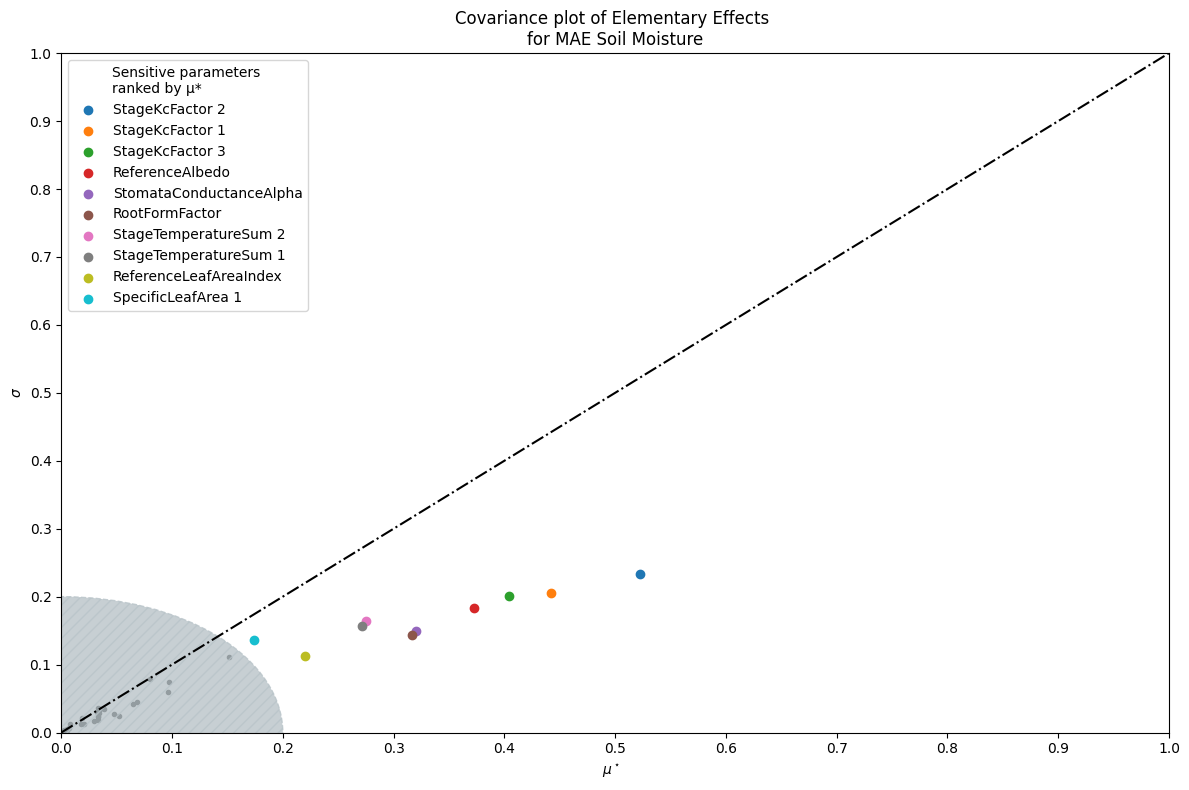

In [15]:
#creating plots for all objective functions for all observations
p1 = morris_covariance(rmse_yield, parameters, "Covariance plot of Elementary Effects \nfor RMSE Yield", morris_sugarbeet, 100)
#p4 = morris_covariance(rmse_irr, parameters, "Covariance plot of Elementary Effects \nfor RMSE Irrigation", morris_wheat, 100)
p7 = morris_covariance(rmse_sm, parameters, "Covariance plot of Elementary Effects \nfor RMSE Soil Moisture", morris_sugarbeet, 100)

p2 = morris_covariance(pbias_yield, parameters, "Covariance plot of Elementary Effects \nfor PBias Yield", morris_sugarbeet, 100)
#p5 = morris_covariance(pbias_irr, parameters, "Covariance plot of Elementary Effects \nfor PBias Irrigation",morris_wheat,  100)
p8 = morris_covariance(pbias_sm, parameters, "Covariance plot of Elementary Effects \nfor PBias Soil Moisture", morris_sugarbeet,100)

p3 = morris_covariance(mae_yield, parameters, "Covariance plot of Elementary Effects \nfor MAE Yield", morris_sugarbeet, 100)
#p6 = morris_covariance(mae_irr, parameters, "Covariance plot of Elementary Effects \nfor MAE Irrigation", morris_wheat, 100)
p9 = morris_covariance(mae_sm, parameters, "Covariance plot of Elementary Effects \nfor MAE Soil Moisture", morris_sugarbeet, 100)

In [16]:
def get_sens_paras(paras_list):
    sens_paras =[]
    for objectives in paras_list:
        for par in objectives:
            if par not in sens_paras:
                sens_paras.append(par)
    return sens_paras

In [17]:
all_obj_list = [p1[0], p2[0], p3[0], p7[0], p8[0], p9[0]]   # p4[0], p5[0], p6[0]
sens_paras = get_sens_paras(all_obj_list)

In [18]:
print(sens_paras, len(sens_paras))

['MaintenanceRespirationParameter2', 'MaintenanceRespirationParameter1', 'MaxAssimilationRate', 'SpecificLeafArea 1', 'StageTemperatureSum 2', 'StageTemperatureSum 1', 'StageKcFactor 2', 'StageKcFactor 3', 'ReferenceAlbedo', 'StageKcFactor 1', 'RootFormFactor', 'StomataConductanceAlpha', 'ReferenceLeafAreaIndex'] 13


#### Morris analysis without objective functions

In [19]:
# num_levels = 20
import numpy as np
import pandas as pd
from SALib.analyze import morris
import matplotlib.pyplot as plt

def calculate_yearly_si(parameters, model_output, problem):
    yearly_si = []
    for yrs in range(model_output.shape[1]):
        X = parameters
        Y = model_output[:,yrs].astype(float)
        si = morris.analyze(problem, X, Y, scaled = True, conf_level = 0.95, num_levels = 20)
        yearly_si.append(si)
    return yearly_si

In [20]:
def mustardistn(model_output_data):
    """Create a boxplot of mu start values across years for each parameter."""

    # rows for the DataFrame
    rows = []
    for year_idx, si in enumerate(model_output_data):
        for param_idx, param_name in enumerate(si["names"]):
            rows.append({
                "Parameter": param_name,
                "Year": year_idx,
                "mu_star": si["mu_star"][param_idx]
            })

    # Create DataFrame
    df = pd.DataFrame(rows)

    # Plot
    plt.figure(figsize=(22, 12))
    sns.boxplot(data=df, x="Parameter", y="mu_star")
    plt.xticks(rotation=90)
    plt.title("Parameter-wise Boxplot of μ* Across All Years")
    plt.ylabel("μ* (mu_star)")
    plt.tight_layout()
    plt.show()


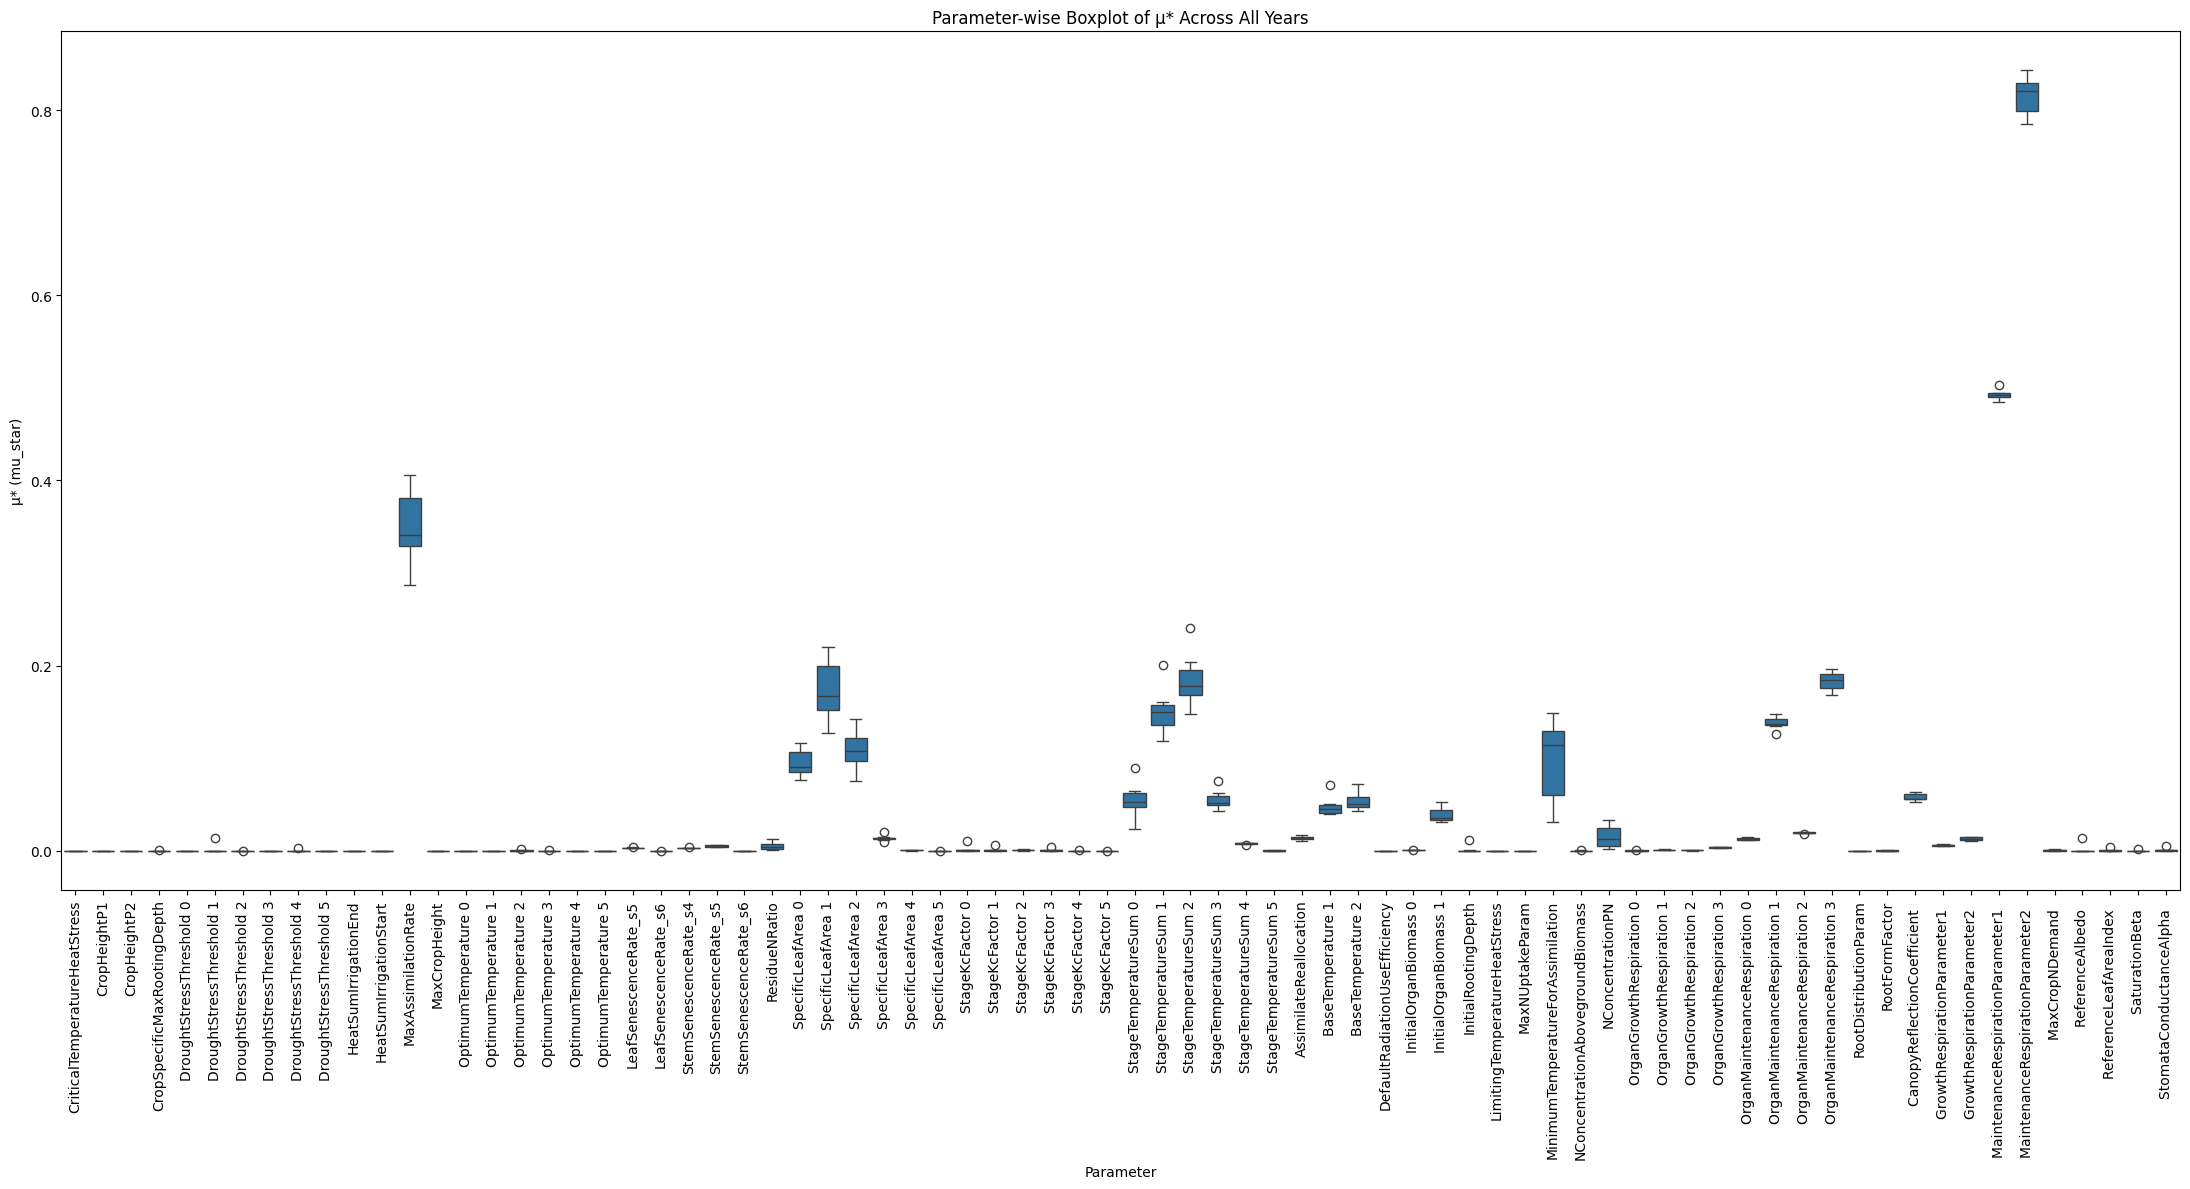

In [21]:
import seaborn as sns
yld_si = calculate_yearly_si(parameters = parameters , model_output = yield_df, problem = morris_sugarbeet)
mustardistn(yld_si)

In [22]:
# irr_si = calculate_yearly_si(parameters = parameters , model_output = irr_df, problem = morris_wheat)
# for yr in range(len(irr_si)):
#     si = irr_si[yr]
#     plot_morris_custom(si, f"Wheat Irr Sensitivity {yr}")

In [23]:
# mustardistn(irr_si)

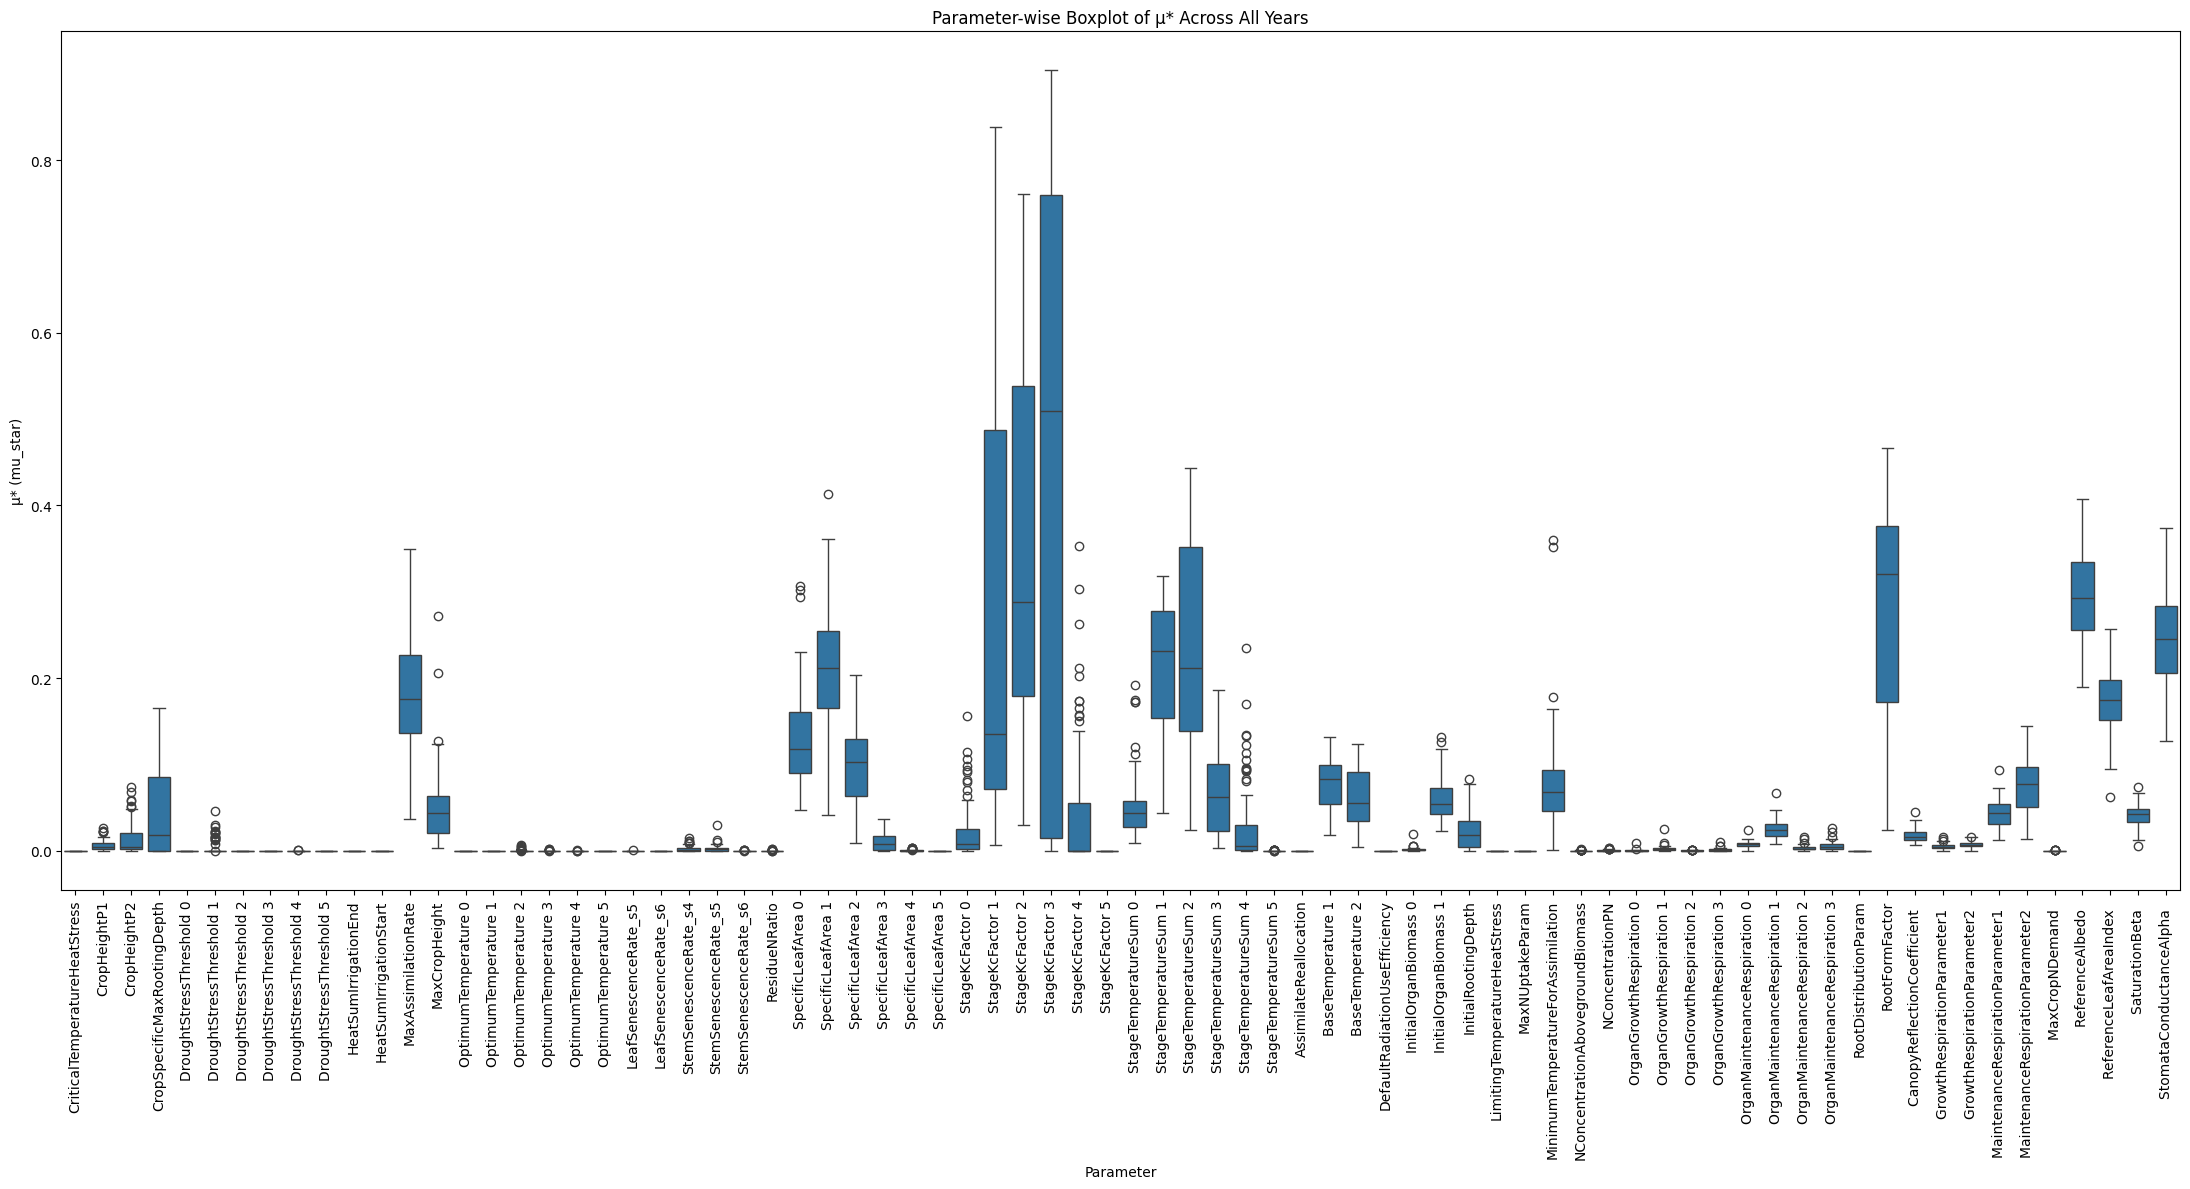

In [24]:
sm_si = calculate_yearly_si(parameters = parameters , model_output = sm_df, problem = morris_sugarbeet)
mustardistn(sm_si)